# Obtaining the data from the Mona File

## Getting the path for Mona file

Using the method load_from_msp, the information inside the Mona file is being obtained.

In [1]:
import os

path = os.path.join(os.path.dirname(os.getcwd()), "data")
msp_file = os.path.join(path, "MoNA-export-GC-MS.msp")

## Appliying filters to the spectra

Applied filters are:
* normalize_intensities(s)
* reduce_to_number_of_peaks(s, **n_required=10**, **ratio_desired=0.5**)
* select_by_mz(s, **mz_from=0**, **mz_to=1000**)
* require_minimum_number_of_peaks(s, **n_required=10**)

In [2]:
from matchms.importing import load_from_msp

spectrums = [s for s in load_from_msp(msp_file)]
print("Number of Spectra:", len(spectrums))

Number of Spectra: 14847


In [3]:
spectrums = [s for s in spectrums if len(s.peaks.intensities) > 0]
print("Remaining Spectra:", len(spectrums))

Remaining Spectra: 14847


In [4]:
import numpy as np

def select_1000_spectra(data):

    reference_sample = np.random.choice(spectrums, 1000)
    query_sample = np.random.choice(spectrums, 1000)
    
    return [[reference_sample[i], query_sample[i]] for i in range(len(reference_sample))]
        
one_k_sample = select_1000_spectra(spectrums)

In [5]:
from matchms.filtering import normalize_intensities
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity

def apply_my_filters(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = select_by_relative_intensity(s, intensity_from=0.05, intensity_to=1.0)
    return s

In [6]:
from datetime import datetime
from matchms import calculate_scores
from matchms.similarity import CosineGreedy
import numpy as np

def calculate_similarity_scores(spectrums, tolerance=0.1):
    
    similarity_measure = CosineGreedy(tolerance, 3.0, 0.6)
    similarity_scores, n_matches = [], []
    
    for s in spectrums:
        similarity_temp, n_matches_temp = similarity_measure(s[0], s[1])
        similarity_scores.append(similarity_temp)
        n_matches.append(n_matches_temp)
    
    return similarity_scores, n_matches

similarities_unfiltered, matches_unfiltered = calculate_similarity_scores(one_k_sample, 0.5)

In [7]:
def filter_spectra(spectrums):
    temp_filtered = []
    for spectre in spectrums:
        temp_filtered.append([apply_my_filters(s) for s in spectre if len(s.peaks.intensities) > 0])
    return temp_filtered    
            
one_k_sample_filtered = filter_spectra(one_k_sample)

In [8]:
def remove_spectrum_without_filter(one_k_sample, one_k_sample_filtered):

    similarities_filtered, num_matches_filtered = [], []
    idx = [k for k, s in enumerate(one_k_sample_filtered) if len(s) < 2]

    for i in idx:
        one_k_sample.pop(i)
        one_k_sample_filtered.pop(i)
        
    return one_k_sample, one_k_sample_filtered

one_k_sample, one_k_sample_filtered = remove_spectrum_without_filter(one_k_sample, one_k_sample_filtered)

In [9]:

similarities_filtered, matches_filtered = calculate_similarity_scores(one_k_sample_filtered, 0.5)


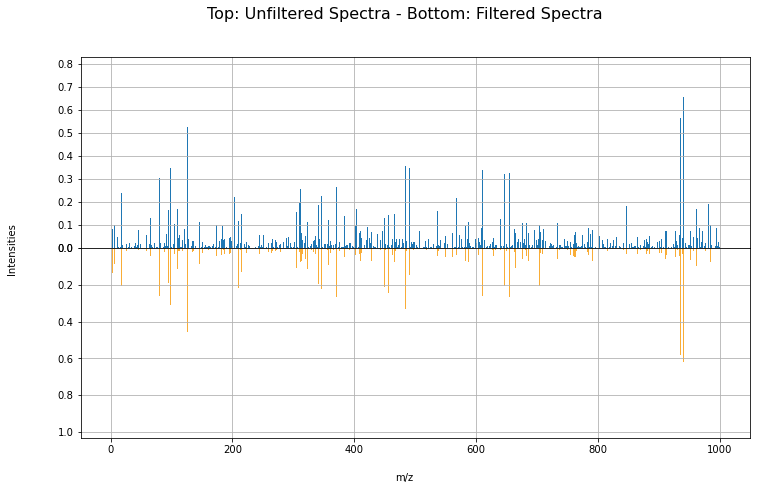

In [10]:
import matplotlib.pyplot as plt
    
def print_mirror_plot(similarities, similarities_filtered):
    size = np.arange(1, len(similarities)+1)
    
    fig, [ax1, ax2] = plt.subplots(2,1, figsize=(12,7))    
    fig.suptitle('Top: Unfiltered Spectra - Bottom: Filtered Spectra', fontsize=16)
    fig.text(0.5, 0.04, 'm/z', ha='center')
    fig.text(0.04, 0.5, 'Intensities', va='center', rotation='vertical')
    plt.subplots_adjust(hspace=0.0)
    ax1.bar(size, similarities)
    ax1.grid(True)
    ax2 = plt.subplot(212)
    plt.bar(size, similarities_filtered, color='#f9ad37') 
    ax2.set_ylim(ax2.get_ylim()[::-1])
    ax2.grid(True)
    plt.show()
    
print_mirror_plot(similarities_unfiltered, similarities_filtered)


<Figure size 864x504 with 0 Axes>

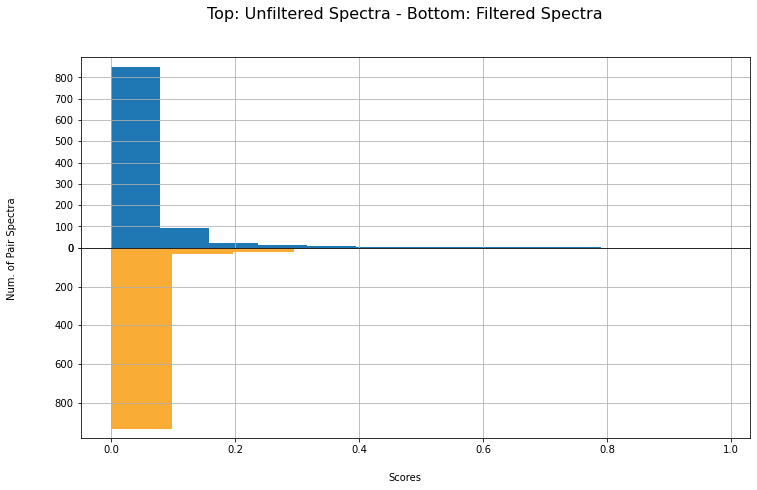

In [11]:
def plot_mirror_histogram(unfiltered, filtered):

    size = np.arange(1, len(unfiltered)+1)
    
    plt.figure(figsize=(12,7))
    fig, [ax1, ax2] = plt.subplots(2,1, sharex=True, figsize=(12,7))
    fig.suptitle('Top: Unfiltered Spectra - Bottom: Filtered Spectra', fontsize=16)
    fig.text(0.5, 0.04, 'Scores', ha='center')
    fig.text(0.04, 0.5, 'Num. of Pair Spectra', va='center', rotation='vertical')
    
    plt.subplots_adjust(hspace=0.0)
    ax1.hist(unfiltered)
    ax1.grid(True)
    
    ax2.hist(filtered, color='#f9ad37')
    ax2.set_ylim(ax2.get_ylim()[::-1])
    ax2.grid(True)
    
    plt.show()
    
plot_mirror_histogram(similarities_unfiltered, similarities_filtered)


In [12]:
one_k_sample = select_1000_spectra(spectrums)
similarities_unfiltered, matches_unfiltered = calculate_similarity_scores(one_k_sample, 0.5)
one_k_sample_filtered = filter_spectra(one_k_sample)
one_k_sample, one_k_sample_filtered = remove_spectrum_without_filter(one_k_sample, one_k_sample_filtered)
similarities_filtered, matches_filtered = calculate_similarity_scores(one_k_sample_filtered, 0.5)

/usr/local/anaconda3/envs/gcms-analysis/lib/python3.7/site-packages/matchms-0.4.0-py3.7.egg/matchms/similarity/spectrum_similarity_functions.py:72: RuntimeWarning: invalid value encountered in double_scalars
  score = score/(numpy.sqrt(numpy.sum(spec1_power**2)) * numpy.sqrt(numpy.sum(spec2_power**2)))


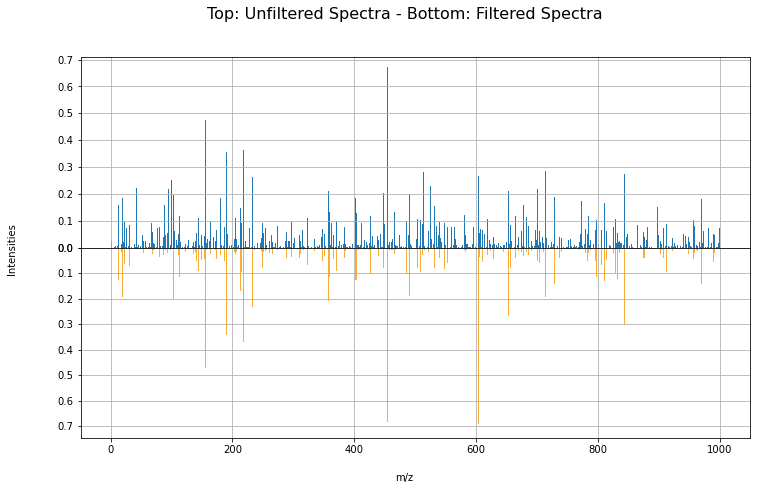

In [13]:
print_mirror_plot(similarities_unfiltered, similarities_filtered)

<Figure size 864x504 with 0 Axes>

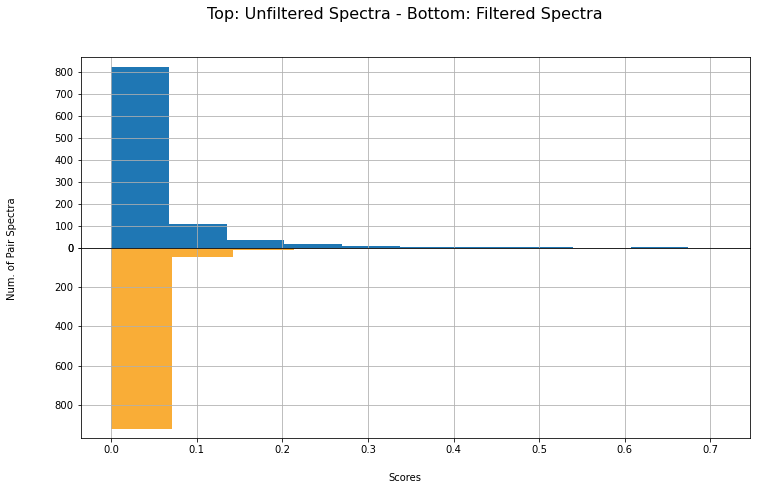

In [14]:
plot_mirror_histogram(similarities_unfiltered, similarities_filtered)